## Imports and Seed Setting

In [2]:
# imports
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import joblib
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.7.0


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Hyperparams of the competition

In [4]:
c_telescope = 1152
sbm_telescope = int(1152*0.75)  #864

## Import and Inspect the Raw Data

In [5]:
# import the data from csv file using pandas

dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.info()

(68528, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


<AxesSubplot:>

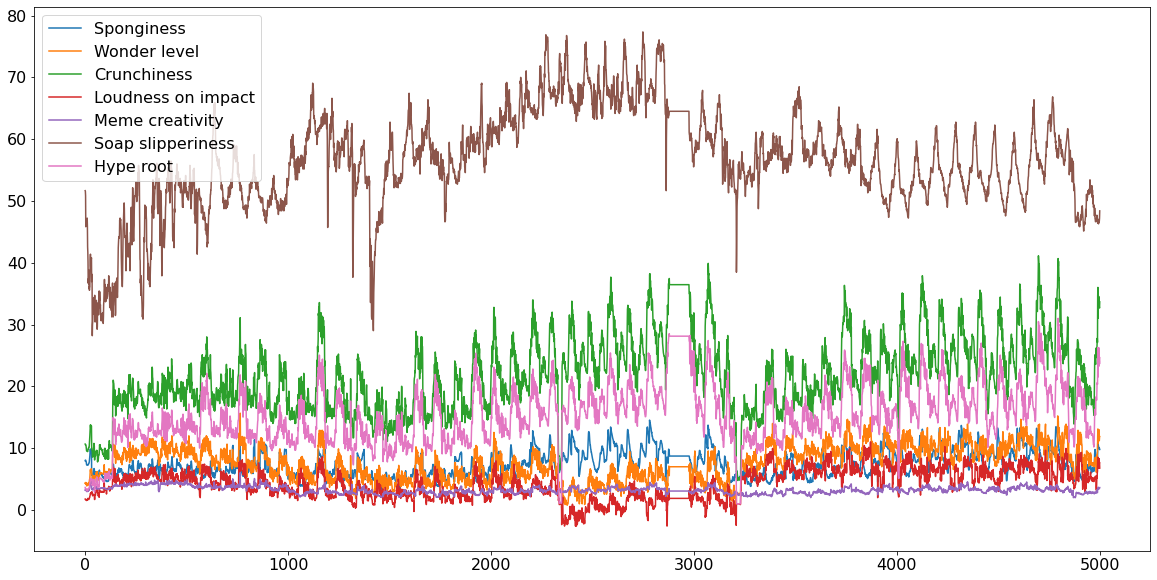

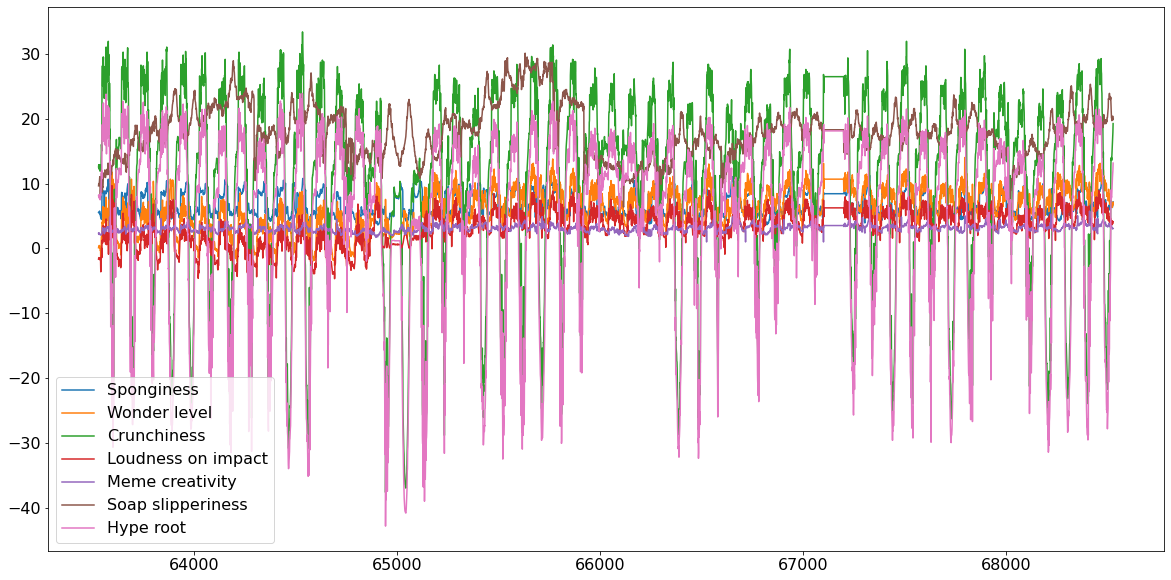

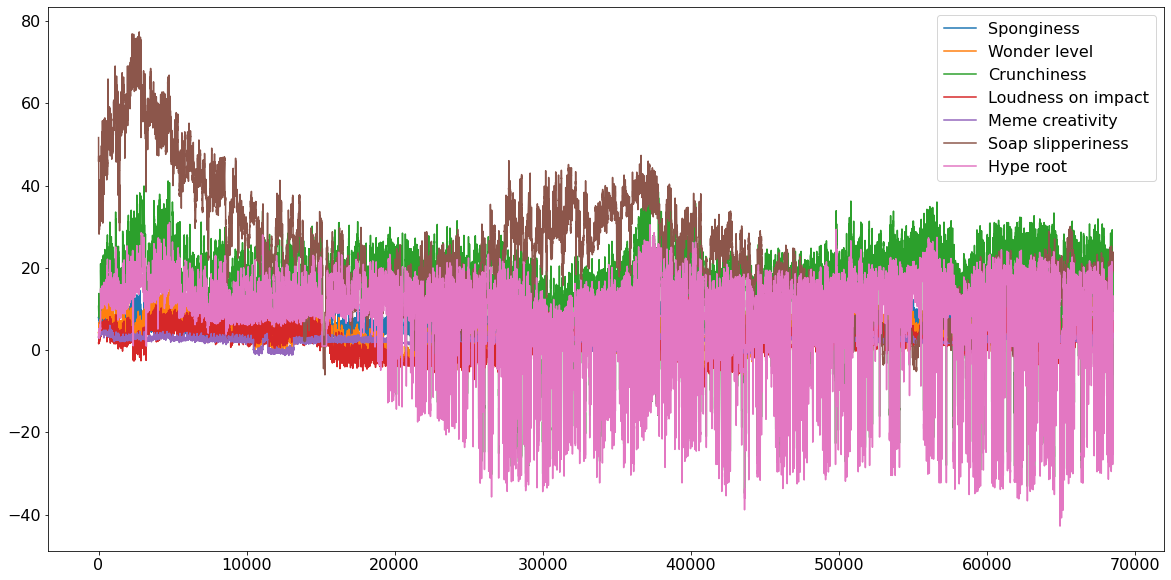

In [6]:
dataset.head(5000).plot.line( figsize=(20,10))
dataset.tail(5000).plot.line( figsize=(20,10))
dataset.plot.line( figsize=(20,10))

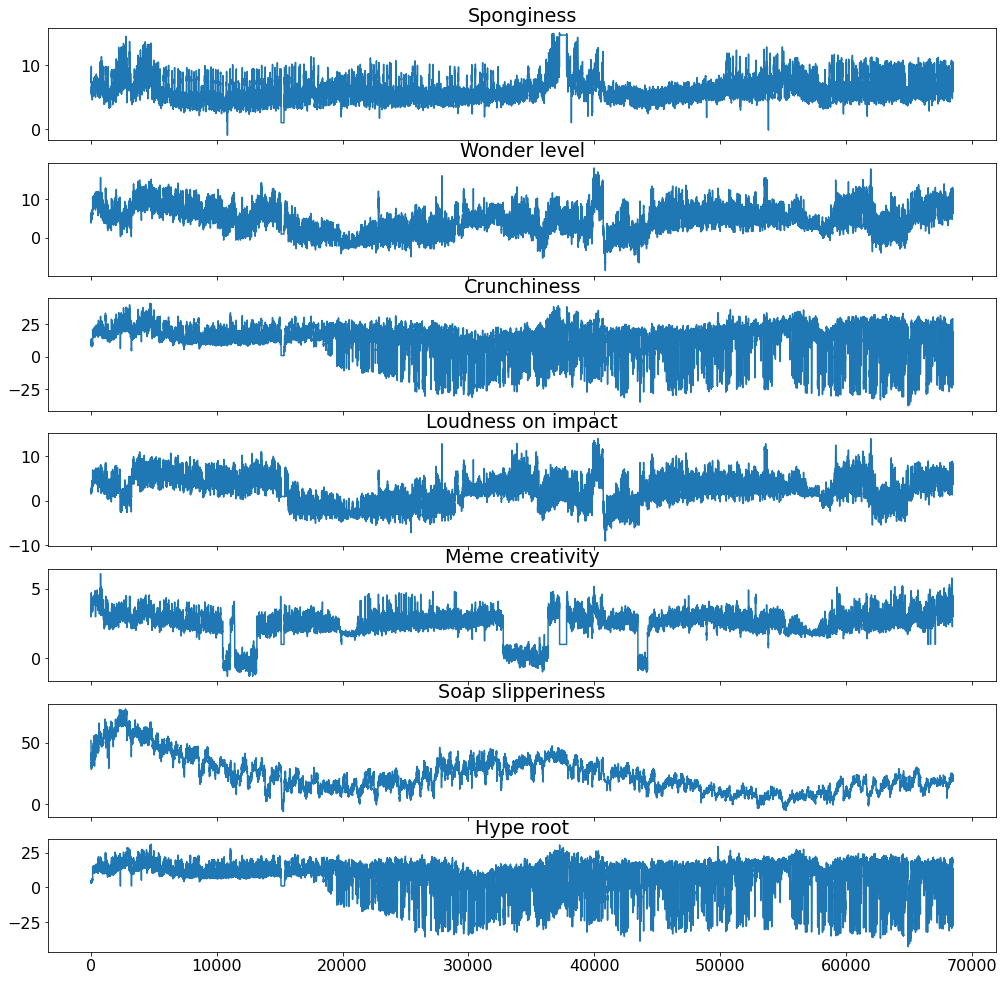

In [8]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(
        len(columns),
        ncols=1,
        sharex=True, 
        figsize=(17,17)
        )
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

inspect_dataframe(dataset, dataset.columns)




## Preprocess the data

In [7]:
# split into test and training datasets
test_size = int(dataset.shape[0]//10) # size of the test set is 10% of the training

X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

In [8]:
#normalize the data

# choice of scaler
scaler = MinMaxScaler()

# fitting the scaler
scaler.fit(X_train_raw)

#transform X_train_raw and X_test_raw
X_pp_train = scaler.transform(X_train_raw)
X_pp_test = scaler.transform(X_test_raw)

# scaler returns numpy arrays (type = ndarray). Reconvert to dataframe for better plotting
data = np.concatenate((X_pp_train,X_pp_test))
data = pd.DataFrame(data, columns = dataset.columns)
X_pp_train = data.iloc[:-test_size]
X_pp_test = data.iloc[-test_size:]

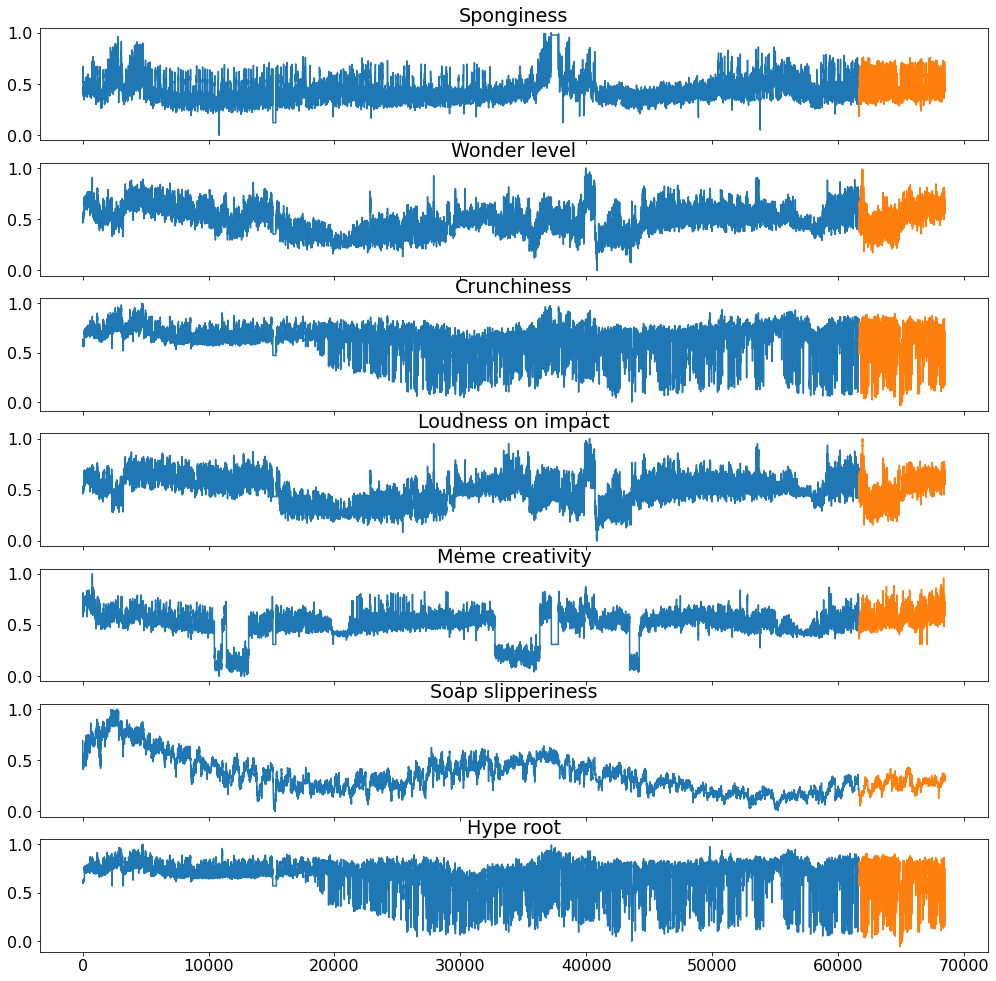

In [9]:
def plot_norm_data(arr1, arr2, columns):
    assert arr1.shape[1] == arr2.shape[1]
    figs, axs = plt.subplots(
        arr1.shape[1],
        ncols=1,
        sharex=True, 
        figsize=(17,17)
        )
    for i, col in enumerate(columns):
        axs[i].plot(arr1.iloc[:, i])
        axs[i].plot(arr2.iloc[:, i])
        axs[i].set_title(col)
    plt.show()
plot_norm_data(X_pp_train, X_pp_test, dataset.columns)


In [10]:
# save the scaler
scaler_dir = 'vars/scalers'
if not os.path.exists(scaler_dir):
    os.makedirs(scaler_dir)

scaler_path = os.path.join(scaler_dir, 'min_max_scaler.gz')
joblib.dump(scaler, scaler_path)

['vars/scalers\\min_max_scaler.gz']

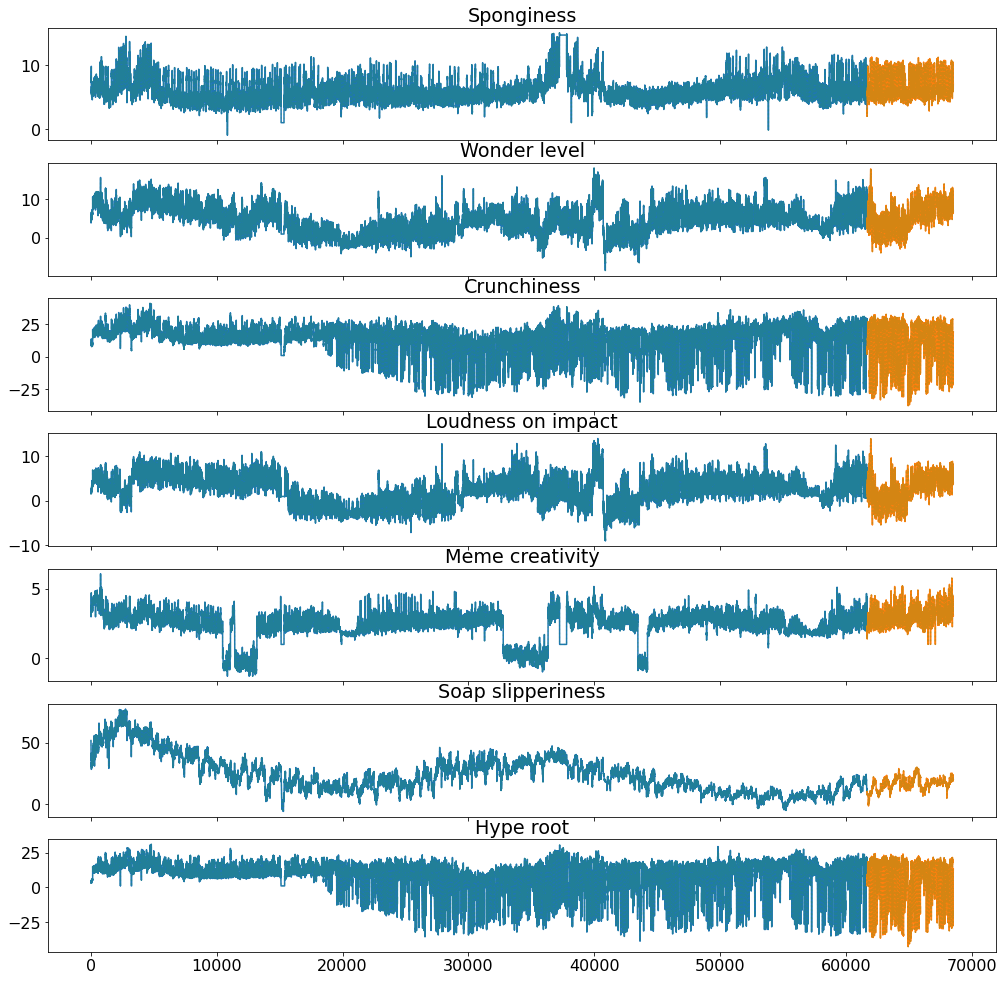

In [11]:
mmscaler = joblib.load(scaler_path)

X = mmscaler.inverse_transform(X_pp_train)
X_t = mmscaler.inverse_transform(X_pp_test)

# scaler returns numpy arrays (type = ndarray). Reconvert to dataframe for better plotting
h = np.concatenate((X,X_t))
h = pd.DataFrame(h, columns = dataset.columns)
X = h.iloc[:-test_size]
X_t = h.iloc[-test_size:]

def plot_norm_data(arr1, arr2, df, columns):
    assert arr1.shape[1] == arr2.shape[1]
    figs, axs = plt.subplots(
        arr1.shape[1],
        ncols=1,
        sharex=True, 
        figsize=(17,17)
        )
    for i, col in enumerate(columns):
        axs[i].plot(arr1.iloc[:, i])
        axs[i].plot(arr2.iloc[:, i])
        axs[i].plot(df[col], linestyle = ':'  ,alpha = 0.2)
        axs[i].set_title(col)
    plt.show()
plot_norm_data(X, X_t, dataset, dataset.columns)


In [12]:
del mmscaler, X, X_t, h 
scaler = joblib.load(scaler_path)

## Create the Sequences

In [11]:
# First objective should be to predict the next quarter of test length. You can look at the instructions for the competition for 
# more information. So the total length to predict is c_telescope = 1152. In the first part of the competition we must predict 3 
# quarters of the total test sequences, i.e. 3/4 * 1152 = 864. One single quarter is made up of 1152/4 = 288. I believe, whatever
# the final structure of the model, that we could firs predict a quarter and then recgressively predict the rest.

quarter_tel = (1152//4) #288

# We can try to predict the quarter in 4 steps of 36

reg = 4
telescope = int(quarter_tel//4) #72
assert quarter_tel%4 == 0

# target labels are all the labels
target_labels = dataset.columns

# Hyper parameters for how to build the sequences. The total length of the dataset is 68528, so quite large. I would take the
# usual length to start with. We will obtain a very large number of sequences. Note that in 
# the inspection of the data the beginning of the sequence seemed quite different from the later evolution. One could consider removing 
# the first part as a possibility. 

window = 200
stride = 20

In [14]:
# build sequence function
def build_sequences(df, target_labels=['pollution'], window=200, stride = 20, telescope=100):
    # check to avoid errrors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values #copy() makes a deep copy
    temp_labels = df[target_labels].copy().values
    need_4_padding = len(df)%window != 0
    
    if(need_4_padding):
        padding_len = window-len(df)%window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_labels.shape[1]), dtype='float64')
        temp_labels = np.concatenate((padding, temp_labels))
        assert len(temp_df)%window == 0
        
    for idx in np.arange(0, len(temp_df)-window-telescope, stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_labels[idx+window:idx+window+telescope])
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [15]:
X_train, y_train = build_sequences(
    X_pp_train,
    target_labels=target_labels,
    window=window,
    stride=stride,
    telescope=telescope
    )
X_test, y_test = build_sequences(
    X_pp_test,
    target_labels=target_labels,
    window=window,
    stride=stride,
    telescope=telescope
    )

In [16]:
# Inspect random sequence

# plotting function 
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
       idx=np.random.randint(0,len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
        # print(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+1))
    plt.show()    

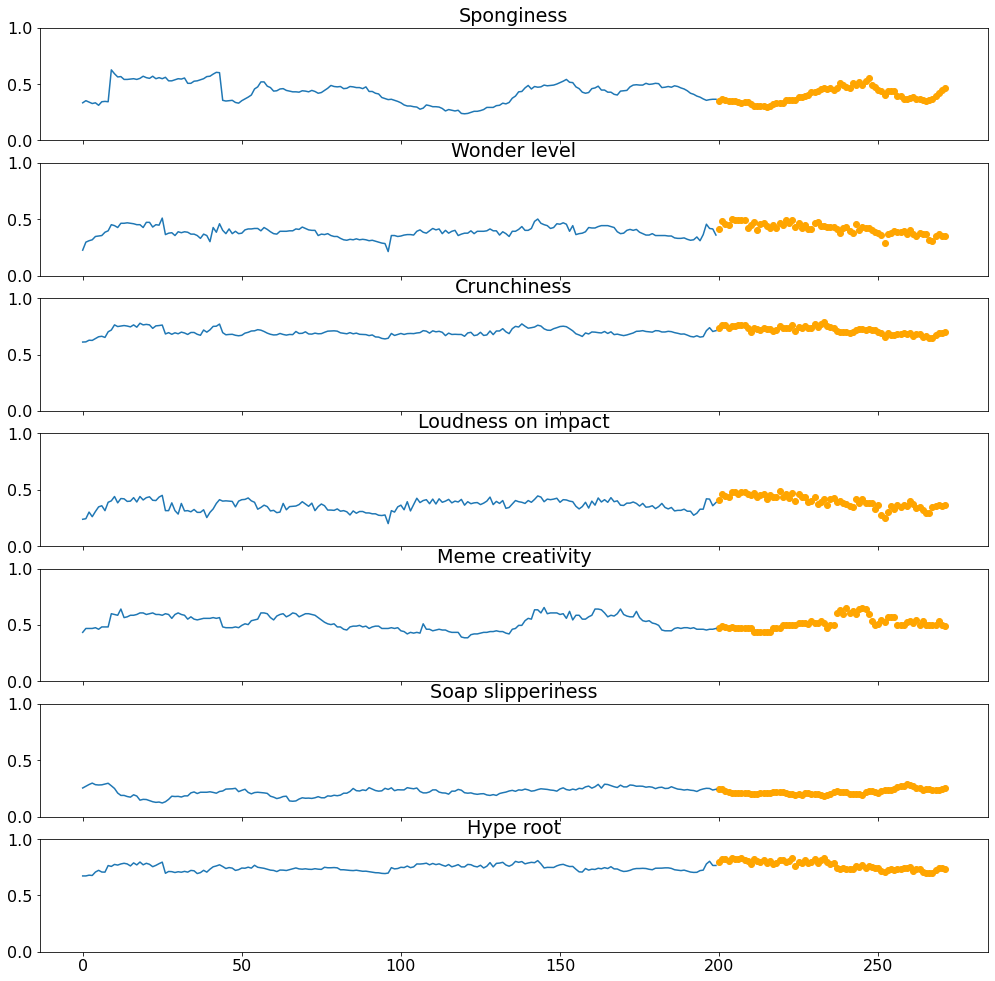

In [17]:
# inspect training sequence
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [7]:
# inspect test sequence
inspect_multivariate(X_test, y_test, target_labels, telescope)

NameError: name 'inspect_multivariate' is not defined

## Build the RNN

In [19]:
# hyperparams

# model hyperparams
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

batch_size = 64
epochs = 200

In [20]:
# Build model layer by layer
def build_CONV_LSTM_model(input_shape, output_shape):
   input_layer = tfkl.Input(shape=input_shape, name='Input')
   
   lyr = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
   lyr = tfkl.Conv1D(128, 3, padding ='same', activation='relu')(lyr)
   lyr = tfkl.MaxPool1D()(lyr)
   lyr = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(lyr)
   lyr = tfkl.Conv1D(256, 3, padding ='same', activation='relu')(lyr)
   lyr = tfkl.GlobalAveragePooling1D()(lyr)
   lyr = tfkl.Dropout(.3)(lyr)
   
   # we want to obtain a number of sequences in output that are 
   # equal to the number of target labels or sensors. 
   # Therefore the output values are telescope*num_sensors
   # we then reshape these values to obtain a tensor with dims
   # (None, telescope, num_sensors)
   dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(lyr)
   output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
   output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    
    #Connect input and output
   model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    #compile the model
   model.compile(
        loss=tfk.losses.MeanSquaredError(), 
        optimizer=tfk.optimizers.Adam(),
        metrics=['mae']
        )
   return model

In [21]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         36864     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 200, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 128)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         263168    
 nal)                                                            
                                                             

In [22]:
#train the RNN
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=10,
            restore_best_weights=True
            ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            patience=5,
            factor=0.5,
            min_lr=1e-5
            ),
        ]
    ).history

Epoch 1/200
44/44 [==============================] - 10s 95ms/step - loss: 0.0971 - mae: 0.2470 - val_loss: 0.0353 - val_mae: 0.1513 - lr: 0.0010
Epoch 2/200
44/44 [==============================] - 3s 71ms/step - loss: 0.0297 - mae: 0.1345 - val_loss: 0.0244 - val_mae: 0.1150 - lr: 0.0010
Epoch 3/200
44/44 [==============================] - 3s 71ms/step - loss: 0.0211 - mae: 0.1119 - val_loss: 0.0207 - val_mae: 0.1069 - lr: 0.0010
Epoch 4/200
44/44 [==============================] - 3s 72ms/step - loss: 0.0181 - mae: 0.1032 - val_loss: 0.0197 - val_mae: 0.1060 - lr: 0.0010
Epoch 5/200
44/44 [==============================] - 3s 72ms/step - loss: 0.0165 - mae: 0.0981 - val_loss: 0.0181 - val_mae: 0.0995 - lr: 0.0010
Epoch 6/200
44/44 [==============================] - 3s 71ms/step - loss: 0.0157 - mae: 0.0955 - val_loss: 0.0179 - val_mae: 0.0986 - lr: 0.0010
Epoch 7/200
44/44 [==============================] - 3s 72ms/step - loss: 0.0155 - mae: 0.0946 - val_loss: 0.0237 - val_mae: 0.11

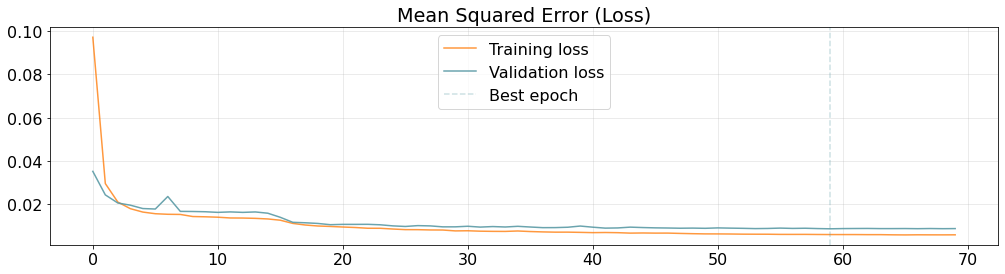

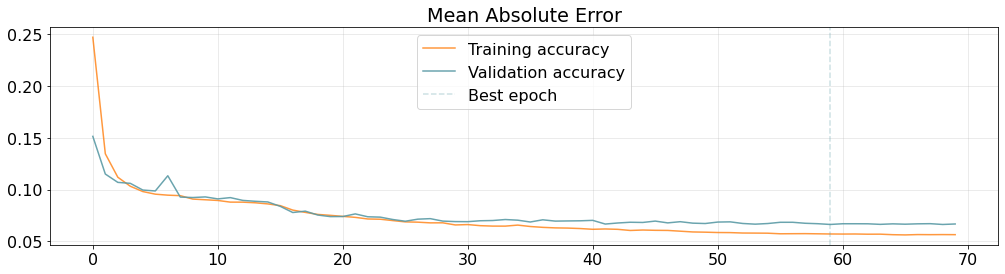

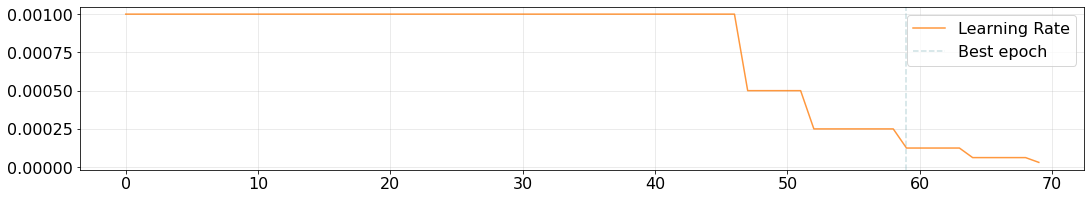

In [23]:
# plot the training

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
# save the model

models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, 'model72')
model.save(model_path)

## Evaluate Performance

### Telescope

In [25]:
# predict the test set
predictions = model.predict(X_test)

# calculate mean errors
mean_squared_error = tfk.metrics.mse(y_test.flatten(), predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(), predictions.flatten())

mean_absolute_error, mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.06718675>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008689824>)

In [26]:
## inspect the performance of the model

def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0, len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()


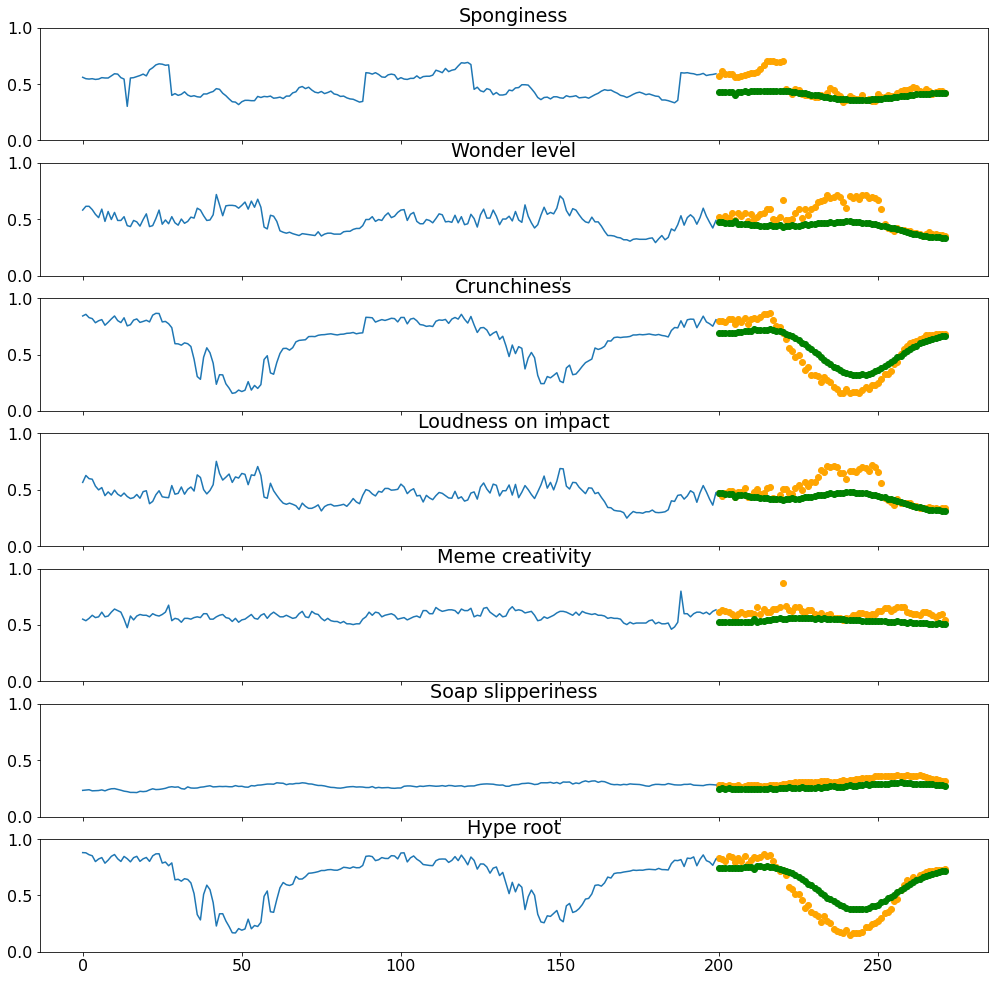

In [27]:
inspect_multivariate_prediction(
    X_test, 
    y_test, 
    predictions, 
    columns=target_labels, 
    telescope=telescope
)

### First Quarter

In [28]:
# quarter_tel = 288

X_test_reg, y_test_reg = build_sequences(
    X_pp_test, 
    target_labels, 
    window, 
    stride, 
    quarter_tel)

In [29]:
def regressive_predict(size, X_temp_in, telescope):
    predictions= np.array([])
    X_temp = X_temp_in
    for reg in range(0,size,telescope):
        pred_temp = model.predict(X_temp)
        if(len(predictions)==0):
            predictions = pred_temp
        else:
            predictions = np.concatenate((predictions, pred_temp), axis=1)
        X_temp = np.concatenate((X_temp[:, telescope: , :], pred_temp), axis=1)
        #this way X_temp always has the same shape
    return predictions 

In [30]:
predictions = regressive_predict(quarter_tel, X_test_reg, telescope)

In [31]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = [] # future mean abs error -> each step
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:, i, j]-predictions[:, i, j])))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [32]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0, len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='blue')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='orange')
        axs[i].fill_between(
            np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), 
            pred[idx,:,i]+maes[:,i], 
            pred[idx,:,i]-maes[:,i], 
            color='orange', alpha=.3
        )
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

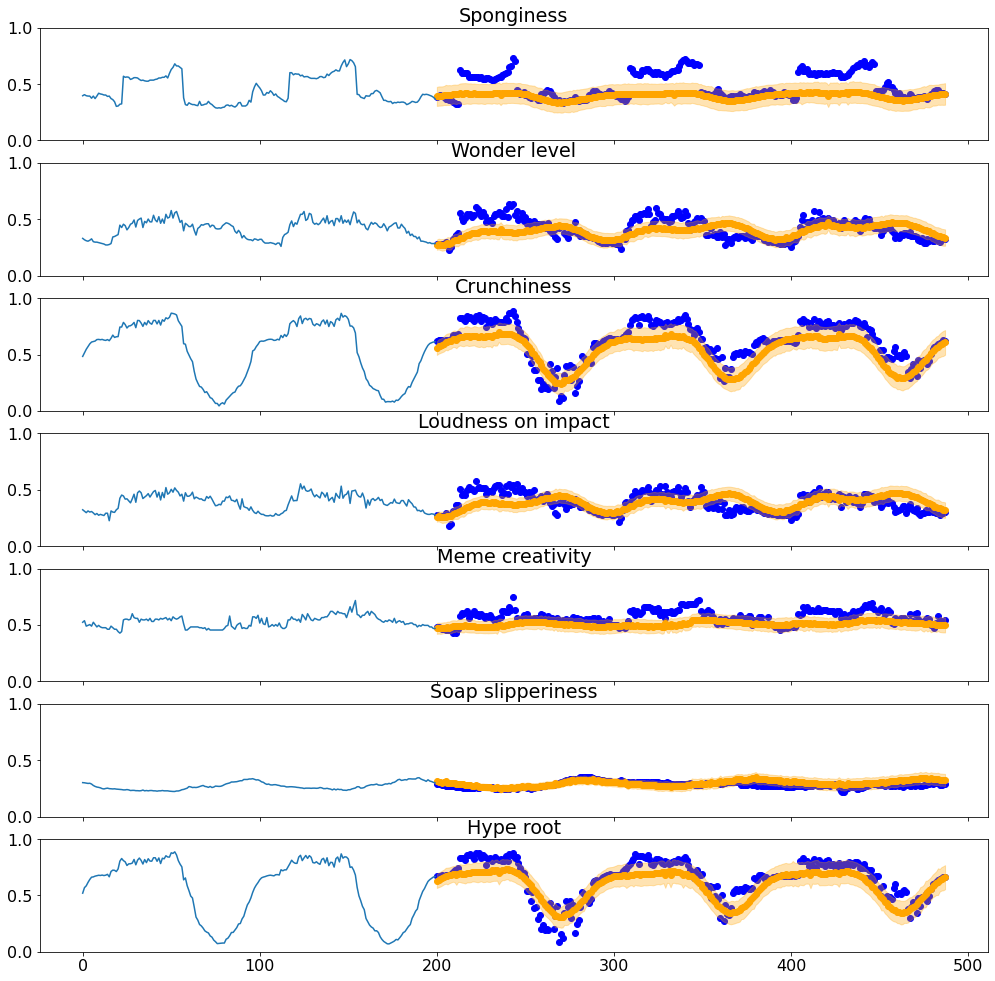

In [33]:
inspect_multivariate_prediction(
    X_test_reg, 
    y_test_reg, 
    predictions, 
    columns=target_labels, 
    telescope=quarter_tel
)

In [34]:
# take the a sequence from the end of the dataset to use for 
# testing and visualization

X_ending = X_pp_test[-window:].to_numpy()
X_ending = np.expand_dims(X_ending, axis=0,)

In [35]:
#because we are chosing the end of the dataframe these are truly predictions!
# there is no true value to compare with

# calculate the 'future' array regressively

future = np.array([])
X_temp = X_ending
for reg in range(0, quarter_tel, telescope):
    pred_temp = model.predict(X_temp)
    if(len(future)==0):
        future = pred_temp
    else:
        future = np.concatenate((future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

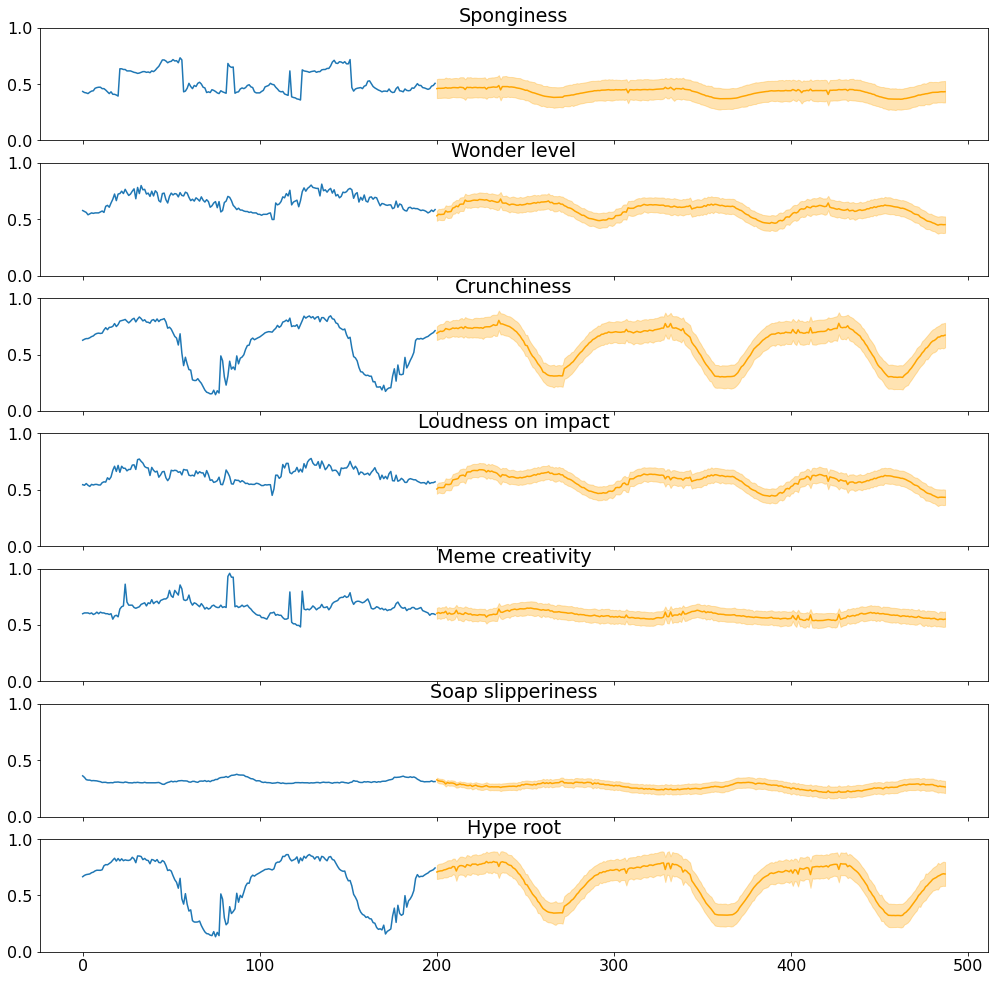

In [36]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(X_ending[0,:,i])), X_ending[0,:,i])
    axs[i].plot(np.arange(len(X_ending[0,:,i]), len(X_ending[0,:,i])+quarter_tel), future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(X_ending[0,:,i]), len(X_ending[0,:,i])+quarter_tel), 
        future[0,:,i]+maes[:,i], 
        future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

### 3 Quarters

In [37]:
# sbm_tel = 864

X_test_reg, y_test_reg = build_sequences(
    X_pp_test, 
    target_labels, 
    window, 
    stride, 
    sbm_telescope)

In [38]:
predictions = regressive_predict(sbm_telescope, X_test_reg, telescope)

In [39]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = [] # future mean abs error -> each step
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:, i, j]-predictions[:, i, j])))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

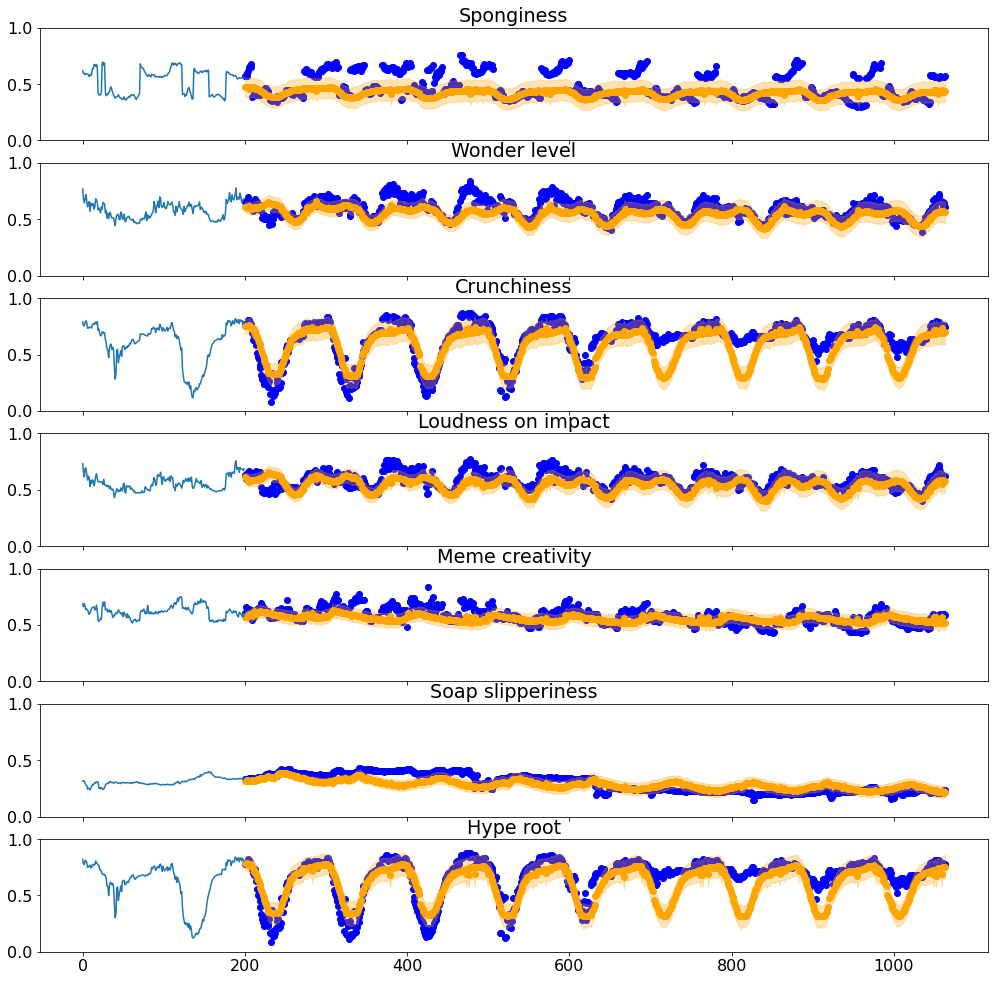

In [40]:
inspect_multivariate_prediction(
    X_test_reg, 
    y_test_reg, 
    predictions, 
    columns=target_labels, 
    telescope=sbm_telescope
)

## Submission Step

In [3]:
#load model
models_dir = 'models'
model_path = os.path.join(models_dir, 'model72')
model = tfk.models.load_model(model_path)

In [4]:
window = 200
scaler_dir = 'vars/scalers'
telescope = 72
reg_telescope = 864

In [5]:
# regressive rpediction function
def regressive_predict(size, X_temp_in, telescope):
        predictions= np.array([])
        X_temp = X_temp_in
        for _ in range(0,size,telescope):
            pred_temp = model.predict(X_temp)
            if(len(predictions)==0):
                predictions = pred_temp
            else:
                predictions = np.concatenate((predictions, pred_temp), axis=1)
            X_temp = np.concatenate((X_temp[:, telescope: , :], pred_temp), axis=1)
            #this way X_temp always has the same shape
        return predictions 

In [8]:
#get X as it will be given in the Submission Model
X_notscaled = dataset.to_numpy()

# Cut the last part of the series on which you perform the submission
X_notscaled= X_notscaled[-window:]


In [9]:
#preprocess X
scaler_path = os.path.join(scaler_dir, 'min_max_scaler.gz')
scaler = joblib.load(scaler_path)
X = scaler.transform(X_notscaled)


In [10]:
#add the batch size of 1
X=np.expand_dims(X, axis=0)

In [11]:
out = regressive_predict(reg_telescope, X, telescope)


In [12]:
# remove batch dimension
out = np.squeeze(out, axis=0)

In [13]:
out = scaler.inverse_transform(out)

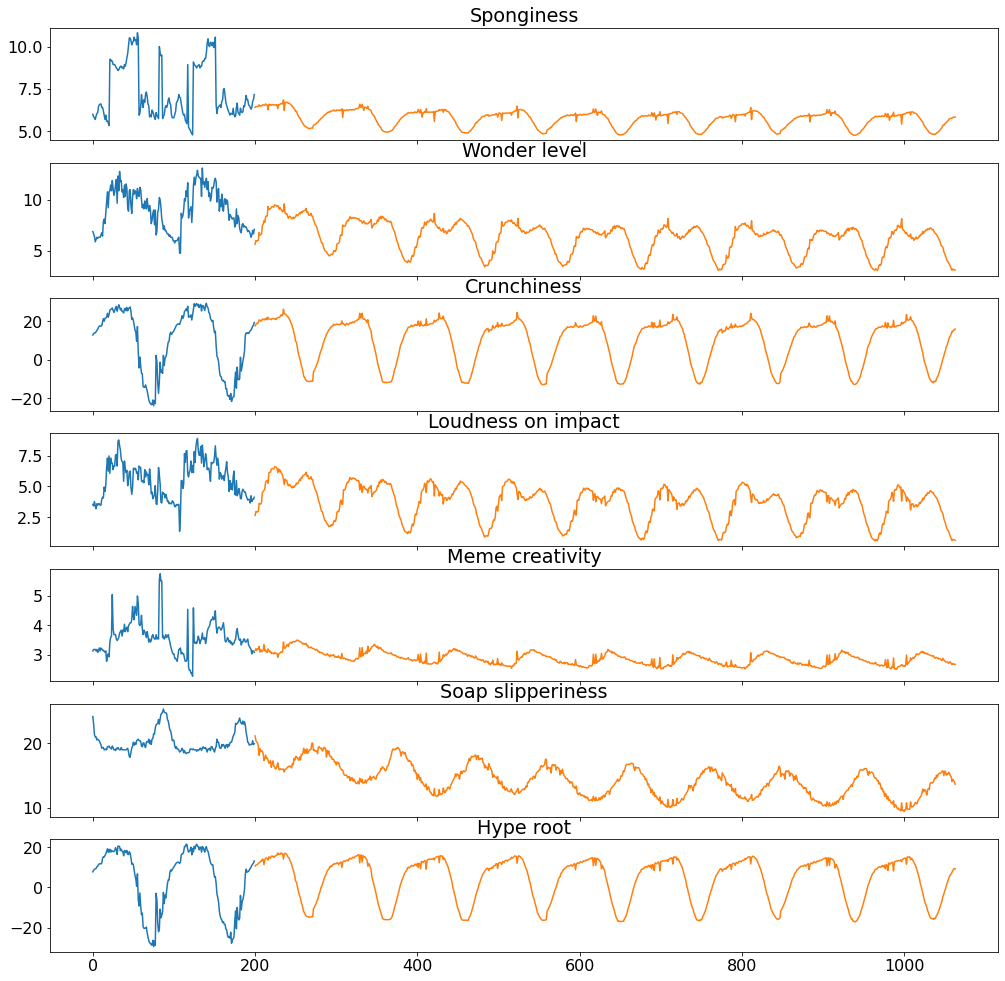

In [14]:
# plot the results
# scaler returns numpy arrays (type = ndarray). Reconvert to dataframe for better plotting

h = np.concatenate((X_notscaled, out))
h = pd.DataFrame(h, columns = dataset.columns)
X_pd = h.iloc[:-reg_telescope]
out_pd = h.iloc[-reg_telescope:]

def plot_norm_data(arr1, arr2, columns):
    assert arr1.shape[1] == arr2.shape[1]
    figs, axs = plt.subplots(
        arr1.shape[1],
        ncols=1,
        sharex=True, 
        figsize=(17,17)
        )
    for i, col in enumerate(columns):
        axs[i].plot(arr1.iloc[:, i])
        axs[i].plot(arr2.iloc[:, i])
        axs[i].set_title(col)
    plt.show()
plot_norm_data(X_pd, out_pd, dataset.columns)

## Test

In [26]:
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))
        self.scaler_dir = 'vars/scalers'
        self.scaler = joblib.load(os.path.join(path, 'vars/scalers', 'min_max_scaler.gz'))
        self.window = 200
        self.telescope = 72
        self.reg_telescope = 864

    def regressive_predict(self, reg_telescope, X_temp_in, telescope):
        predictions= np.array([])
        X_temp = X_temp_in
        for _ in range(0,reg_telescope,telescope):
            pred_temp = self.model.predict(X_temp)
            if(len(predictions)==0):
                predictions = pred_temp
            else:
                predictions = np.concatenate((predictions, pred_temp), axis=1)
            X_temp = np.concatenate((X_temp[:, telescope: , :], pred_temp), axis=1)
            #this way X_temp always has the same shape
        return predictions 

    def predict(self, X):
        X=X.numpy()
        #take the final slice from the end of the sequence that we want to forecast
        X = X[-self.window:]

        #preprocess the data
        X = self.scaler.transform(X)

        #add the batch dimesion = 1
        X=np.expand_dims(X, axis=0)

        # predict the output sequence
        out = self.regressive_predict(self.reg_telescope, X, self.telescope)

        # Insert your postprocessing here
        #invert the preprocessing transform
        out = np.squeeze(out, axis=0)
        out = self.scaler.inverse_transform(out)
        
        # output MUST BE TENSOR
        out = tf.convert_to_tensor(out)
        return out

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>